In [1]:
# Libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

#load the data
#YYYY-MM-DD
df = pd.read_csv('../nyc_data.csv')
future_df = pd.read_csv('../future.csv')
future_df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2021,NaN,0,0,0,5.00,154.221
1,1/2/2021,NaN,0,0,0,11.11,264.805
2,1/3/2021,NaN,0,0,0,3.89,115.499
3,1/4/2021,NaN,0,0,0,6.67,124.650
4,1/5/2021,NaN,0,0,0,5.56,77.968


In [2]:
# Merge both datasets
df = pd.concat([df, future_df])
df = df.reset_index(drop = True)
df.tail()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
2218,1/27/2021,NaN,0,0,0,3.33,39.664
2219,1/28/2021,NaN,0,0,0,1.67,195.314
2220,1/29/2021,NaN,0,0,0,-2.78,235.894
2221,1/30/2021,NaN,0,0,0,1.11,152.752
2222,1/31/2021,NaN,0,0,0,4.44,158.620


In [3]:
#Rename variable
df = df.rename(columns = {'Demand': 'y',
                          'Date': 'ds'})
df.head(1)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305


In [4]:
# Date variable
df.ds = pd.to_datetime(df.ds,
               format  = "%m/%d/%Y")
df.ds

0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
2218   2021-01-27
2219   2021-01-28
2220   2021-01-29
2221   2021-01-30
2222   2021-01-31
Name: ds, Length: 2223, dtype: datetime64[ns]

# Holidays

In [5]:
# Easter
dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({"holiday": "easter",
                       "ds": dates,
                       "lower_window": -5,
                       "upper_window": 2})

In [6]:
# Thanksgiving
dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({"holiday": "thanksgiving",
                       "ds": dates,
                       "lower_window": -3,
                       "upper_window": 6})

In [7]:
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6
1792,thanksgiving,2019-11-28,-3,6
2156,thanksgiving,2020-11-26,-3,6


In [8]:
# Combining events
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [9]:
# Removing the holiday columns
df = df.drop(["Easter", "Thanksgiving"], axis = 1)

In [10]:
# Split data
training = df.iloc[:-31,:]
future_df = df.iloc[-31:,:]

In [11]:
# Fetch the parameters
parameters = pd.read_csv('best_params_prophet.csv',
                         index_col = 0)

In [12]:
# Extract the parameter values
changepoint_prior_scale = float(parameters.loc['changepoint_prior_scale'][0])
holidays_prior_scale = float(parameters.loc['holidays_prior_scale'][0])
seasonality_prior_scale = float(parameters.loc['seasonality_prior_scale'][0])
seasonality_mode = parameters.loc['seasonality_mode'][0]

In [13]:
# FB model
m = Prophet(holidays = holidays,
            seasonality_mode = seasonality_mode,
            seasonality_prior_scale = seasonality_prior_scale,
            holidays_prior_scale = holidays_prior_scale,
            changepoint_prior_scale = changepoint_prior_scale)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(training)

07:48:12 - cmdstanpy - INFO - Chain [1] start processing
07:48:13 - cmdstanpy - INFO - Chain [1] done processing


# Forecasting

In [15]:
# Make a future dataframe
future = m.make_future_dataframe(periods = len(future_df),
                        freq = 'D') # W for weekly or M for monthly
future = pd.concat([future, df.iloc[:,2:]], axis = 1)
future.head()

,ds,Christmas,Temperature,Marketing
0,2015-01-01,0,3.68,41.305
1,2015-01-02,0,4.73,131.574
2,2015-01-03,0,7.23,162.700
3,2015-01-04,0,10.96,160.281
4,2015-01-05,0,6.92,51.077


In [16]:
# Forecasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Marketing,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,593.236646,618.181232,756.548981,593.236646,593.236646,0.0,0.0,0.0,-3.416527,...,-4.033546,-4.033546,-4.033546,89.795045,89.795045,89.795045,0.0,0.0,0.0,686.785598
1,2015-01-02,593.357661,529.570565,668.534169,593.357661,593.357661,0.0,0.0,0.0,0.196021,...,-89.472751,-89.472751,-89.472751,88.458802,88.458802,88.458802,0.0,0.0,0.0,602.705635
2,2015-01-03,593.478676,645.644905,783.039351,593.478676,593.478676,0.0,0.0,0.0,1.441678,...,25.220130,25.220130,25.220130,87.287022,87.287022,87.287022,0.0,0.0,0.0,715.121793
3,2015-01-04,593.599690,560.476495,699.499117,593.599690,593.599690,0.0,0.0,0.0,1.344870,...,-55.636916,-55.636916,-55.636916,86.298247,86.298247,86.298247,0.0,0.0,0.0,629.612532
4,2015-01-05,593.720705,694.160026,824.621318,593.720705,593.720705,0.0,0.0,0.0,-3.025454,...,74.311047,74.311047,74.311047,85.505474,85.505474,85.505474,0.0,0.0,0.0,758.512541


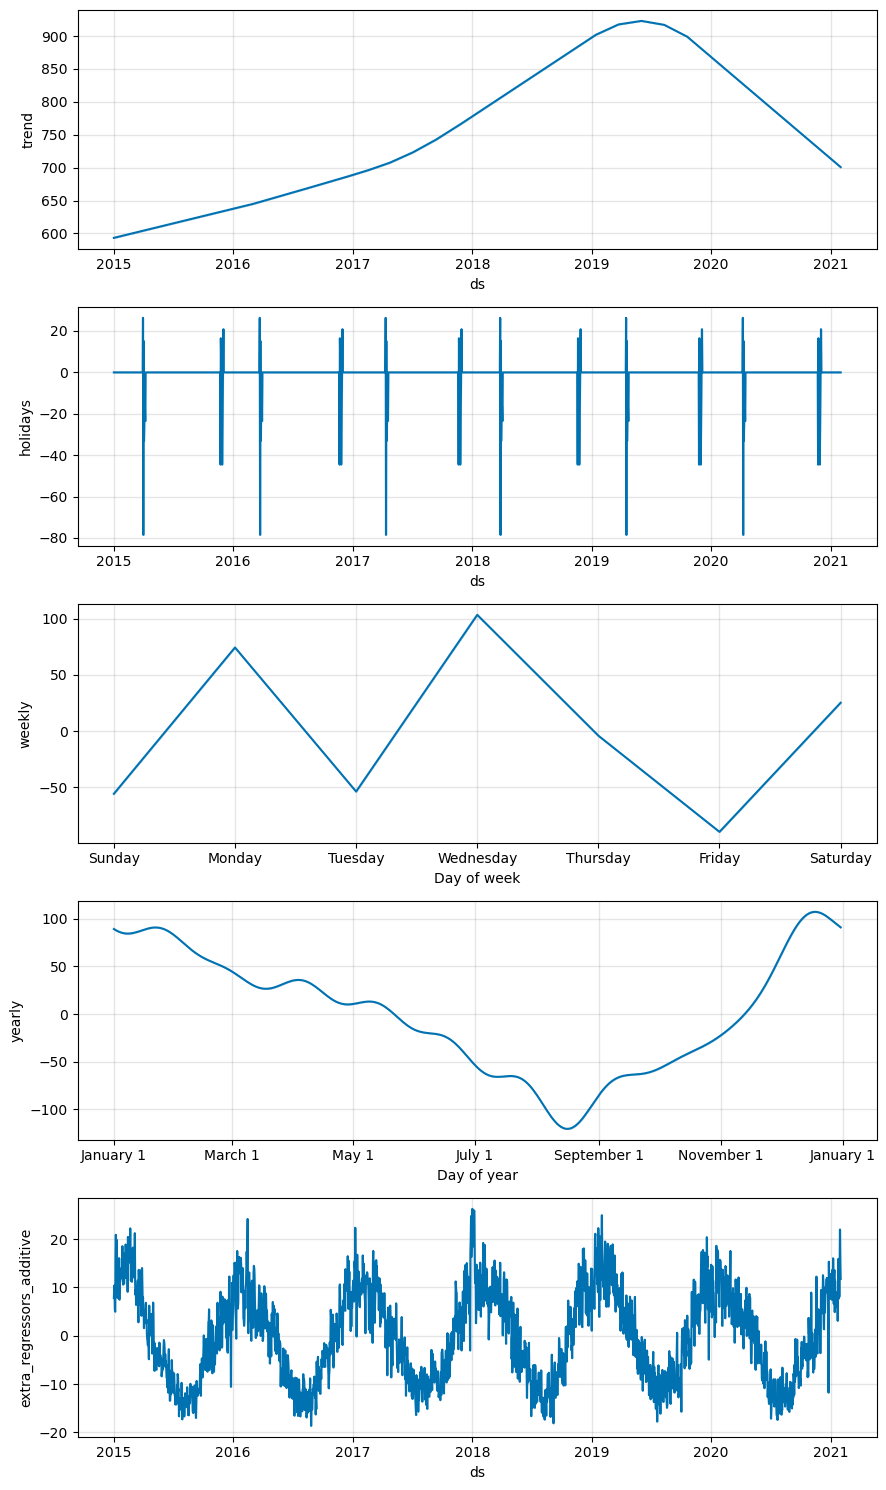

In [18]:
# Plotting
m.plot_components(forecast);

In [22]:
# Extract the predictions
predictions_prophet = forecast.yhat[-len(future_df):].rename("prophet")
predictions_prophet.index = future_df["ds"]

In [23]:
# Export 
predictions_prophet.to_csv("Ensemble/predictions_prophet.csv")